In [ ]:
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import os
import math
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
import seaborn as sns
from sklearn import metrics
import time
import pickle
import metric_learn
from sklearn.decomposition import PCA  
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import LocalOutlierFactor
import functools
import tempfile
import datetime
import tensorflow as tf
import mlflow
from mlflow.models import infer_signature
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from utils import make_data, make_data_rev, make_label, calc_leq, leq_filter, validate, figure, figure_detail, plot_timeseries, fig_pr, auc_gs, fig_th_f

## ベンチマークデータ

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_train = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)
df_train.columns=['original']
df_train.reset_index(inplace=True, drop=True)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_test = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)
df_test.columns=['original']
df_test.reset_index(inplace=True, drop=True)

window=8
df_train=make_data_rev(df_train, 'original', window)
df_train=df_train.dropna().reset_index(drop=True)
df_train.loc[:, 'day']=0
df_train.loc[:, 'label']=0
df_train.loc[:, 'lstmaed']=0
df_train.loc[:, 'lstmaed_label']=0

df_test=make_data_rev(df_test, 'original', window)
df_test=df_test.dropna().reset_index(drop=True)
df_test.loc[:, 'day']=0
df_test.loc[:, 'label']=0
df_test.loc[:, 'lstmaed']=0
df_test.loc[:, 'lstmaed_label']=0

Epoch 1/100
32/32 [==============================] - 7s 46ms/step - loss: 0.2012 - val_loss: 0.1225
Epoch 2/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0835 - val_loss: 0.0704
Epoch 3/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0531 - val_loss: 0.0576
Epoch 4/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0420 - val_loss: 0.0533
Epoch 5/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0404 - val_loss: 0.0529
Epoch 6/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0403 - val_loss: 0.0518
Epoch 7/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0399 - val_loss: 0.0513
Epoch 8/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0397 - val_loss: 0.0499
Epoch 9/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0395 - val_loss: 0.0487
Epoch 10/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0390 - val_loss: 0.0471

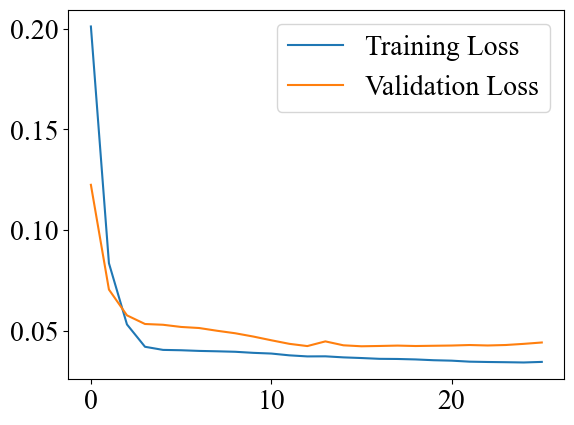

126/126 [==============================] - 1s 5ms/step


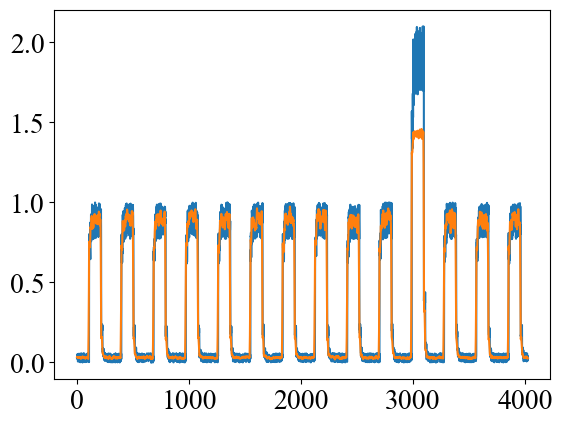

In [3]:
units=32
LSTM_autoencoder = keras.Sequential()
LSTM_autoencoder.add(keras.layers.LSTM(
    units=units,
    input_shape=(window, 1),
))
# LSTM_autoencoder.add(keras.layers.Dropout(rate=0.5))
LSTM_autoencoder.add(keras.layers.RepeatVector(n=window))
LSTM_autoencoder.add(keras.layers.LSTM(
    units=units, 
    return_sequences=True,
))
# LSTM_autoencoder.add(keras.layers.Dropout(rate=0.5))
LSTM_autoencoder.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=1)
  )
)
###############################################################################

semi_train_x=df_train[df_train.columns[:-4]].reset_index(drop=True)
labeling_x=df_test[df_test.columns[:-4]].reset_index(drop=True)
# tf.reduce_min関数を使用して、train_dataテンソル内の最小値を計算しています。
# min_valにはtrain_data内の最小値が代入されます。
min_val = tf.reduce_min(semi_train_x)
# tf.reduce_max関数を使用して、train_dataテンソル内の最大値を計算しています。
# max_valにはtrain_data内の最大値が代入されます。
max_val = tf.reduce_max(semi_train_x)
train_data = (semi_train_x.values - min_val) / (max_val - min_val)
labeling_data = (labeling_x.values - min_val) / (max_val - min_val)

# データをモデルに入力する形状に整形し,データの型をtf.float32に変換
train_data = tf.cast(train_data[:, :, np.newaxis], tf.float32)
labeling_data = tf.cast(labeling_data[:, :, np.newaxis], tf.float32)

LSTM_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                         loss='mae')

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    restore_best_weights=True
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = LSTM_autoencoder.fit(train_data, train_data, 
      epochs=100, 
      batch_size=128,
      validation_data=(labeling_data, labeling_data),
      callbacks=[callback, tensorboard_callback],
      shuffle=True)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

reconstructions = LSTM_autoencoder.predict(labeling_data)

#     異常度算出
d= tf.keras.losses.mae(reconstructions[:, :, 0], labeling_data[:, :, 0]).numpy()
test_v=df_test[['original', 'label']].copy().reset_index(drop=True)
d_test=(d-d.min())/(d.max()-d.min())

plt.plot(labeling_data[:, 0, 0])
plt.plot(reconstructions[:, 0, 0])
plt.show()